In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import cv2
import os
import segyio
import cmapy
import seaborn as sns
import pandas as pd

# Data Analyze

In [2]:
def z_score(seis, ignore_zero=True):
    if ignore_zero:
        non_zero_slice = seis != 0.0
        mean = np.mean(seis[non_zero_slice])
        std = np.std(seis[non_zero_slice])
        seis[non_zero_slice] = (seis[non_zero_slice] - mean) / std
        return seis
    else:
        return (seis - seis.mean()) / seis.std()

In [3]:
def get_sample(seis, fault=None, num_sample=100):
    if fault is not None:
        assert seis.shape == fault.shape
    inline_select = np.random.choice(seis.shape[0], size=num_sample)
    xline_select = np.random.choice(seis.shape[1], size=num_sample)
    timeline_select = np.random.choice(seis.shape[2], size=num_sample)
    
    seis_sample = seis[inline_select, xline_select, timeline_select]
    if fault is not None:
        fault_sample = fault[inline_select, xline_select, timeline_select]
        return z_score(seis_sample.copy(), ignore_zero=True), fault_sample.copy().astype(bool)
    else:
        return z_score(seis_sample.copy(), ignore_zero=True)

In [4]:
num_sample = 10000
print('Loading Thebe')
thebe_seis = np.load('Fault_data/public_data/precessed/train/seis/seistrain.npy', mmap_mode='r')
thebe_fault = np.load('Fault_data/public_data/precessed/train/fault/faulttrain.npy', mmap_mode='r')
thebe_seis_sample, thebe_fault_sample = get_sample(thebe_seis, thebe_fault, num_sample)
print('Loading Simulate Data')
sync_seis = np.fromfile('Fault_data/simulate_data/train/seis/59.dat', dtype=np.single).reshape(128, 128, 128)
sync_fault = np.fromfile('Fault_data/simulate_data/train/fault/59.dat', dtype=np.single).reshape(128, 128, 128)
sync_seis_sample, sync_fault_sample = get_sample(sync_seis, sync_fault, num_sample)
print('Loading Pretrained Data-1')
pretrained_data_1 = get_sample(segyio.tools.cube('Fault_data/project_data_v1/unlabeled/chahetai/chjSmall_mig.sgy'), fault=None, num_sample=num_sample)
print('Loading Pretrained Data-2')
pretrained_data_2 = get_sample(segyio.tools.cube('Fault_data/project_data_v1/labeled/qyb/seis/20230412_QY-PSTM-STK-CG-TO-DIYAN.sgy'), fault=None, num_sample=num_sample)

Loading Thebe
Loading Simulate Data
Loading Pretrained Data-1
Loading Pretrained Data-2


In [5]:
# generate seaborn data
Work_Field = pd.Series(['Thebe Dataset' for _ in range(num_sample)] + ['Synthetic Dataset' for _ in range(num_sample)] + ['Pre-training-1 Dataset' for _ in range(num_sample)] + ['Pre-training-2 Dataset' for _ in range(num_sample)], name='Work Field')
Seismic = pd.Series(thebe_seis_sample.tolist() + sync_seis_sample.tolist() + pretrained_data_1.tolist() + pretrained_data_2.tolist(), name='Seismic')
Fault = pd.Series(thebe_fault_sample.tolist() + sync_fault_sample.tolist() + [None for _ in range(num_sample)] + [None for _ in range(num_sample)], name='Fault')
df = pd.concat([Work_Field, Seismic, Fault], axis=1)

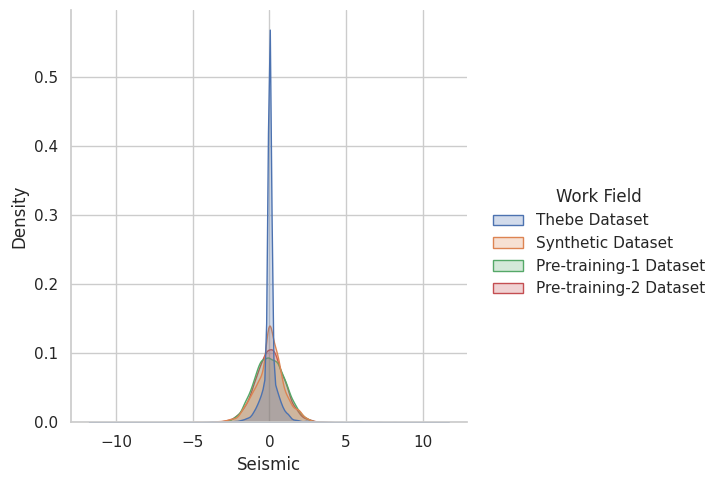

In [6]:
# 使用 Seaborn 绘制概率密度图
sns.set(style="whitegrid")  # 设置样式，可选
# sns.set_theme()
sns.displot(df, x="Seismic", hue="Work Field", kind='kde', fill=True)
plt.savefig('distribution.png', dpi=300)

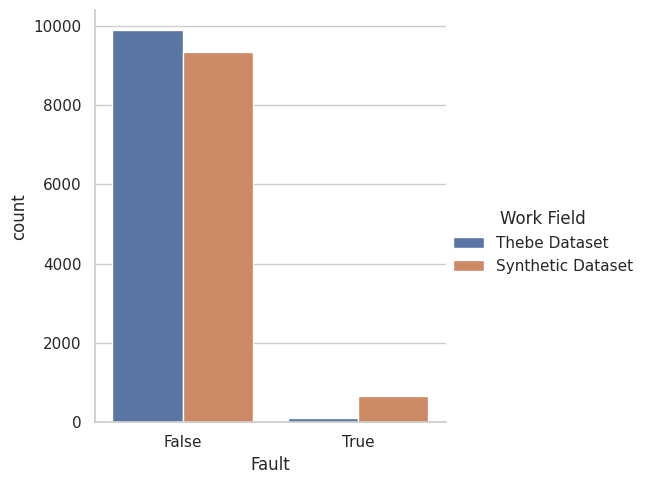

In [7]:
sns.catplot(df.loc[:2*num_sample-1, :], x='Fault', hue='Work Field', kind='count')
plt.savefig('fault_distribution.png', dpi=300)

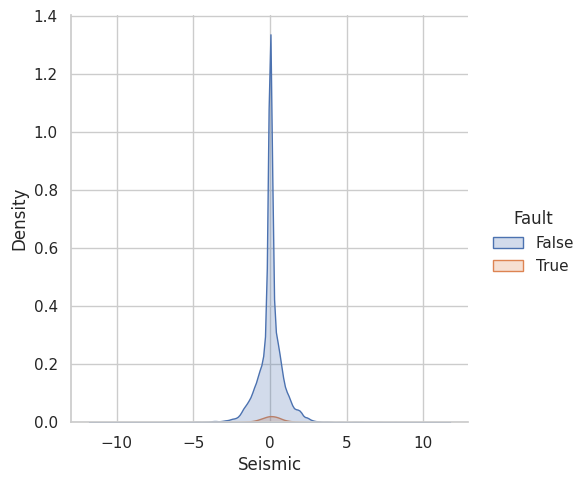

In [8]:
sns.displot(data=df.loc[:2*num_sample-1, :], x="Seismic", hue="Fault", kind='kde', fill=True)
plt.savefig('fault_distribution_1.png', dpi=300)

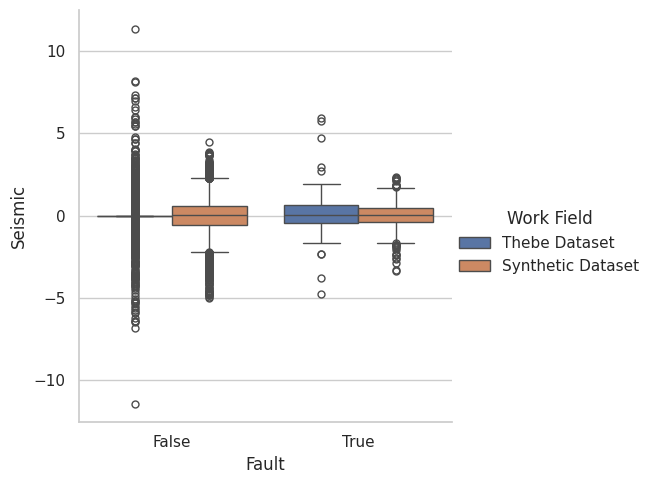

In [9]:
sns.catplot(data=df.loc[:2*num_sample-1, :], x='Fault', y='Seismic', hue='Work Field', kind='box')
plt.savefig('box_plot.png', dpi=300)

# Vis Thebe

In [3]:
# LOWER_BOUND = 800
# UPPER_BOUND = 1300
LOWER_BOUND = 0
UPPER_BOUND = -1


seis = np.load('./Fault_data/public_data/precessed/test/seis/seistest.npy', mmap_mode='r')
gt = np.load('./Fault_data/public_data/precessed/test/fault/faulttest.npy', mmap_mode='r')
# faultseg_swin_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_multi_decoder_fusion_overall_simmim300e_p16_public_256_flip_rotate_aug_4x4/thebe_pred/score.npy', mmap_mode='r')
# faultseg_swin_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_public_whole_random_crop_1x4/thebe_pred/seistest_score.npy', mmap_mode='r')
faultseg_swin_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_public_256_flip_rotate_aug_4x4_rerun/thebe_min_max_pred/seistest_score.npy', mmap_mode='r')
swin_unetr_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_public_256_flip_rotate_aug_4x4_rerun/thebe_pred/seistest_score.npy', mmap_mode='r')
anyu_unet_pred = np.load('/home/zhangzr/anyu_fault_recong/CNNforFaultInterpretation/anyu_pred/thebe/unet_smooth/thebe_test_pred_score.npy', mmap_mode='r')
anyu_deep_lab_pred = np.load('/home/zhangzr/anyu_fault_recong/CNNforFaultInterpretation/anyu_pred/thebe/deeplab_smooth/thebe_test_pred_score.npy', mmap_mode='r')
anyu_hed_pred = np.load('/home/zhangzr/anyu_fault_recong/CNNforFaultInterpretation/anyu_pred/thebe/hed_smooth/thebe_test_pred_score.npy', mmap_mode='r')
anyu_rcf_pred = np.load('/home/zhangzr/anyu_fault_recong/CNNforFaultInterpretation/anyu_pred/thebe/rcf_smooth/thebe_test_pred_score.npy', mmap_mode='r')

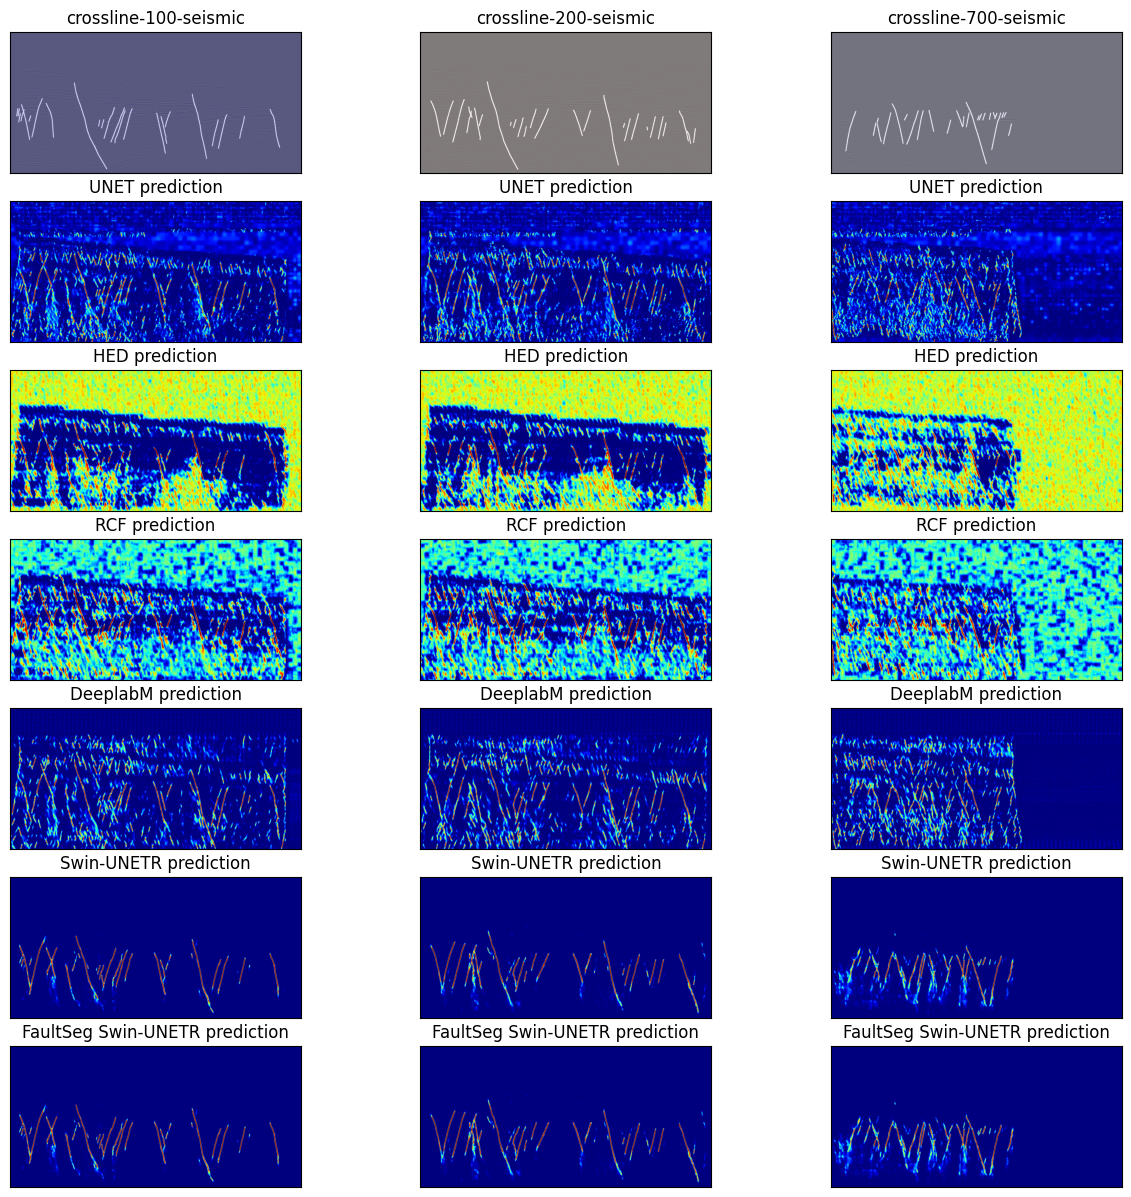

In [4]:
idxs = [100, 200, 700]
# idxs = [100, 200]
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax=plt.subplots(7,len(idxs))
for col, idx in enumerate(idxs):
    ax[0, col].imshow(seis[idx, :, LOWER_BOUND:UPPER_BOUND].T, cmap='seismic')
    ax[0, col].imshow(gt[idx, :, LOWER_BOUND:UPPER_BOUND].T, cmap='gray', alpha=0.5)
    ax[0, col].axes.set_title(f'crossline-{idx}-seismic')
    ax[0, col].axes.xaxis.set_visible(False)
    ax[0, col].axes.yaxis.set_visible(False)
    
    ax[1, col].imshow(cv2.applyColorMap((anyu_unet_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[1, col].axes.set_title(f'UNET prediction')
    ax[1, col].axes.xaxis.set_visible(False)
    ax[1, col].axes.yaxis.set_visible(False)
    
    ax[2, col].imshow(cv2.applyColorMap((anyu_hed_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[2, col].axes.set_title(f'HED prediction')
    ax[2, col].axes.xaxis.set_visible(False)
    ax[2, col].axes.yaxis.set_visible(False)
    
    ax[3, col].imshow(cv2.applyColorMap((anyu_rcf_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[3, col].axes.set_title(f'RCF prediction')
    ax[3, col].axes.xaxis.set_visible(False)
    ax[3, col].axes.yaxis.set_visible(False)
    
    ax[4, col].imshow(cv2.applyColorMap((anyu_deep_lab_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[4, col].axes.set_title(f'DeeplabM prediction')
    ax[4, col].axes.xaxis.set_visible(False)
    ax[4, col].axes.yaxis.set_visible(False)
    
    ax[5, col].imshow(cv2.applyColorMap((swin_unetr_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[5, col].axes.set_title(f'Swin-UNETR prediction')
    ax[5, col].axes.xaxis.set_visible(False)
    ax[5, col].axes.yaxis.set_visible(False)  
    
    ax[6, col].imshow(cv2.applyColorMap((faultseg_swin_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[6, col].axes.set_title(f'FaultSeg Swin-UNETR prediction')
    ax[6, col].axes.xaxis.set_visible(False)
    ax[6, col].axes.yaxis.set_visible(False)
    
plt.show()

# Vis Sync Trained Thebe

In [10]:
seis = np.load('./Fault_data/public_data/precessed/test/seis/seistest.npy', mmap_mode='r')
gt = np.load('./Fault_data/public_data/precessed/test/fault/faulttest.npy', mmap_mode='r')

faultseg_swin_unetr_sync_trained_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_multi_decoder_fusion_overall_simmim300e_p16_sync_flip_rotate_aug/thebe_pred/seistest_score.npy', mmap_mode='r')
swin_unetr_sync_trained_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_simulate_data_flip_rotate_aug_1x4/thebe_pred/seistest_score.npy', mmap_mode='r')

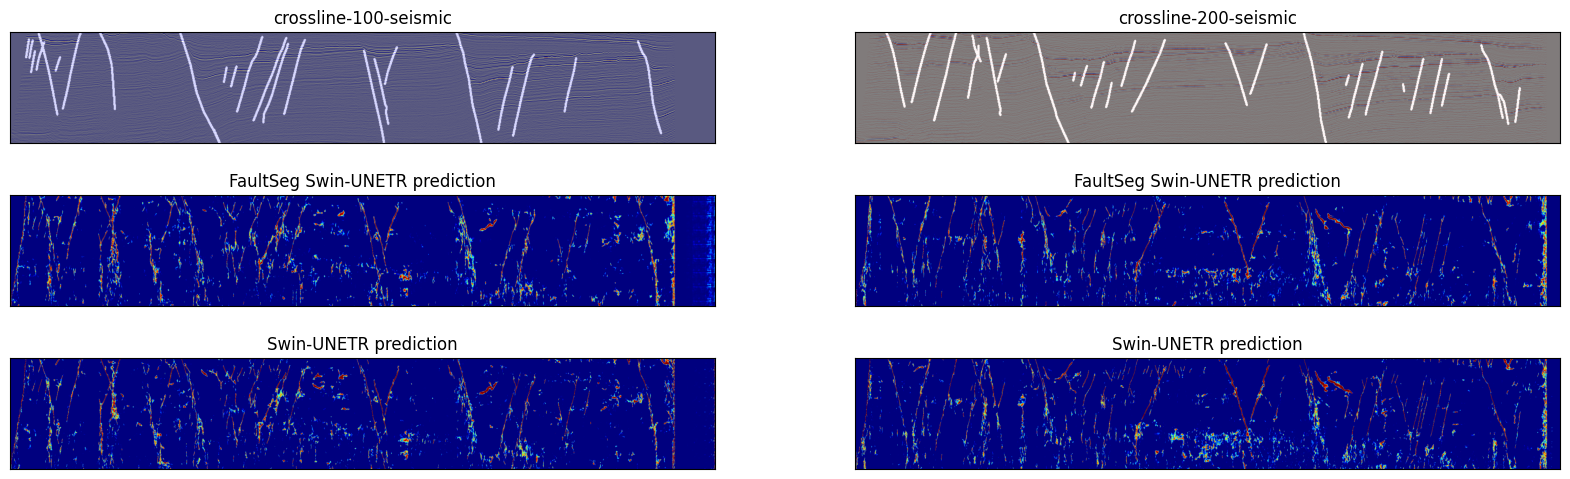

In [18]:
# idxs = [0, 100, 200]
idxs = [100, 200]
LOWER_BOUND = 800
UPPER_BOUND = 1300
plt.rcParams["figure.figsize"] = (20, 6)
fig, ax=plt.subplots(3,len(idxs))
for col, idx in enumerate(idxs):
    ax[0, col].imshow(seis[idx, :, LOWER_BOUND:UPPER_BOUND].T, cmap='seismic')
    ax[0, col].imshow(gt[idx, :, LOWER_BOUND:UPPER_BOUND].T, cmap='gray', alpha=0.5)
    ax[0, col].axes.set_title(f'crossline-{idx}-seismic')
    ax[0, col].axes.xaxis.set_visible(False)
    ax[0, col].axes.yaxis.set_visible(False)
    
    ax[1, col].imshow(cv2.applyColorMap((faultseg_swin_unetr_sync_trained_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[1, col].axes.set_title(f'FaultSeg Swin-UNETR prediction')
    ax[1, col].axes.xaxis.set_visible(False)
    ax[1, col].axes.yaxis.set_visible(False)
    
    ax[2, col].imshow(cv2.applyColorMap((swin_unetr_sync_trained_pred[idx, :, LOWER_BOUND:UPPER_BOUND].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[2, col].axes.set_title(f'Swin-UNETR prediction')
    ax[2, col].axes.xaxis.set_visible(False)
    ax[2, col].axes.yaxis.set_visible(False)
    
plt.show()

# Vis F3

In [5]:
seis = segyio.tools.cube('./Fault_data/OD-Servey/F3_Demo_2020/Export/1_Original_Seismics.sgy')
thined_fault_likelihood = segyio.tools.cube('./Fault_data/OD-Servey/F3_Demo_2020/Export/Fault_Likelihood_Thinned_from_DSMF_seis.sgy')

faultseg_swin_unetr_thebe_trained_pred = np.load('./MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_multi_decoder_fusion_overall_simmim300e_p16_public_256_flip_rotate_aug_4x4/F3_Pred/1_Original_Seismics_score.npy', mmap_mode='r')
faultseg_swin_unetr_sync_trained_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_multi_decoder_fusion_overall_simmim300e_p16_sync_flip_rotate_aug/F3_Pred/1_Original_Seismics_score.npy', mmap_mode='r')
swin_unetr_thebe_trained_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_public_256_flip_rotate_aug_4x4_rerun/F3_Pred/1_Original_Seismics_score.npy', mmap_mode='r')
swin_unetr_sync_pred = np.load('MIM-Med3D/output/Fault_Finetuning/swin_unetr_base_simmim500e_p16_simulate_data_flip_rotate_aug_1x4/F3_Pred/1_Original_Seismics_score.npy', mmap_mode='r')

swin_2d_mix_pred = np.load('mmsegmentation/output/swin-base-patch4-window7_upernet_8xb2-160k_mix_data_v3_force_3_chan-512x512_per_image_normal_simmim_2000e/F3_Pred/score_inline.npy', mmap_mode='r')

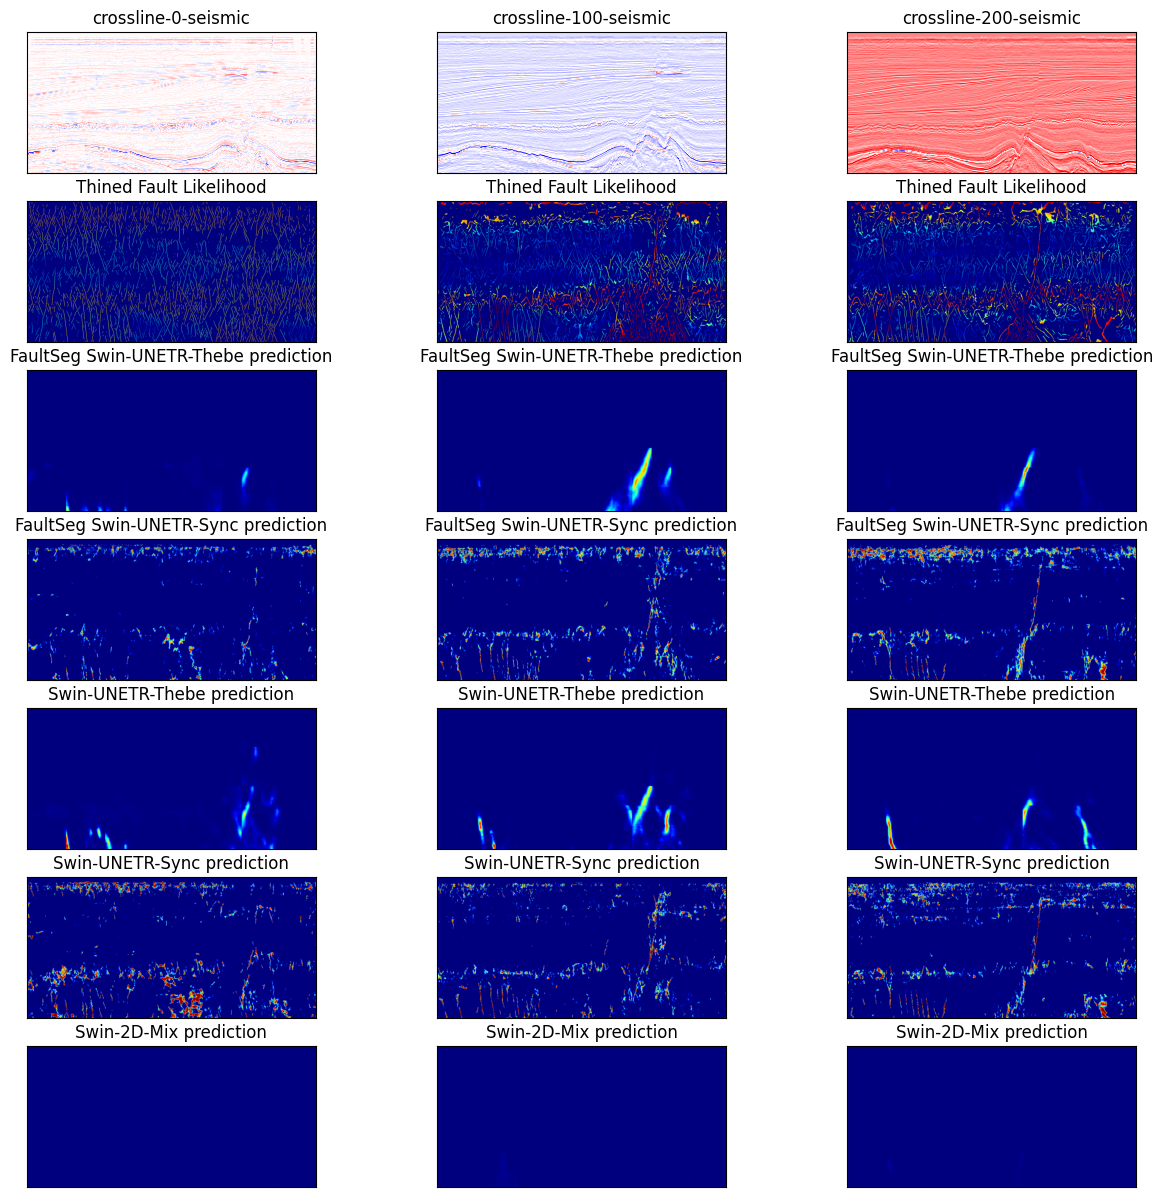

In [6]:
idxs = [0, 100, 200]
# idxs = [100, 200]
plt.rcParams["figure.figsize"] = (15, 15)
fig, ax=plt.subplots(7,len(idxs))
for col, idx in enumerate(idxs):
    ax[0, col].imshow(seis[idx, :, :].T, cmap='seismic')
    ax[0, col].axes.set_title(f'crossline-{idx}-seismic')
    ax[0, col].axes.xaxis.set_visible(False)
    ax[0, col].axes.yaxis.set_visible(False)
    
    ax[1, col].imshow(cv2.applyColorMap((thined_fault_likelihood[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[1, col].axes.set_title(f'Thined Fault Likelihood')
    ax[1, col].axes.xaxis.set_visible(False)
    ax[1, col].axes.yaxis.set_visible(False)
    
    ax[2, col].imshow(cv2.applyColorMap((faultseg_swin_unetr_thebe_trained_pred[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[2, col].axes.set_title(f'FaultSeg Swin-UNETR-Thebe prediction')
    ax[2, col].axes.xaxis.set_visible(False)
    ax[2, col].axes.yaxis.set_visible(False)
    
    ax[3, col].imshow(cv2.applyColorMap((faultseg_swin_unetr_sync_trained_pred[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[3, col].axes.set_title(f'FaultSeg Swin-UNETR-Sync prediction')
    ax[3, col].axes.xaxis.set_visible(False)
    ax[3, col].axes.yaxis.set_visible(False)
    
    ax[4, col].imshow(cv2.applyColorMap((swin_unetr_thebe_trained_pred[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[4, col].axes.set_title(f'Swin-UNETR-Thebe prediction')
    ax[4, col].axes.xaxis.set_visible(False)
    ax[4, col].axes.yaxis.set_visible(False)
    
    ax[5, col].imshow(cv2.applyColorMap((swin_unetr_sync_pred[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[5, col].axes.set_title(f'Swin-UNETR-Sync prediction')
    ax[5, col].axes.xaxis.set_visible(False)
    ax[5, col].axes.yaxis.set_visible(False) 
    
    ax[6, col].imshow(cv2.applyColorMap((swin_2d_mix_pred[idx, :, :].T*255).astype(np.uint8), cmapy.cmap('jet_r')))
    ax[6, col].axes.set_title(f'Swin-2D-Mix prediction')
    ax[6, col].axes.xaxis.set_visible(False)
    ax[6, col].axes.yaxis.set_visible(False) 
    
plt.show()